# A real-world Example: The Causal Story Behind Hotel Booking Cancellations

We consider the problem of estimating the impact of assigning a different hotel room as compared to what the customer had originally reserved.

The gold standard of finding this out would be to use experiments such as Randomized Controlled Trials wherein each customer is randomly assigned to one of the two categories i.e. each customer is either assigned a different room or the same room as he had booked before. But what if we cannot intervene or its too costly too perform such an experiment (Ex- The Hotel would start losing its reputation if people learn that its randomly assigning people to different rooms). Can we somehow answer our query using only observational data or data that has been collected in the past?

This dataset contains booking information for a city hotel and a resort hotel taken from a real hotel in Portugal, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. All personally identifying information has been removed from the data.

![img](img/ch7/Hotel.png)

This dataset contains booking information for a city hotel and a resort hotel taken from a real hotel in Portugal, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things. All personally identifying information has been removed from the data.

Additional details on how the daataset has been created can be found in the original [article](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by *Antonio et. al for Data in Brief, Volume 22, February 2019* or [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md).

## Load Data

In [53]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [54]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## Feature Engineering & Pre-Processing

Lets create some new and meaningful features so as to reduce the dimensionality of the dataset. 
The following features have been created:

- Total Stay = stays_in_weekend_nights + stays_in_week_nights
- Guests = adults + children + babies
- Different_room_assigned = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

We also remove other columns that either contain *NULL* values or have too many unique values (e.g., *agent ID*). 
We also impute missing values of the *country* column with the most frequent country. We remove *distribution_channel* since it has a high overlap with *market_segment*.

In [55]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Delete rows where guests=nan
dataset = dataset.drop(dataset.loc[pd.isna(dataset["guests"]), :].index)
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type', 'required_car_parking_spaces', 
                        'total_of_special_requests', 'adr', 'distribution_channel', 'deposit_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'reservation_status',
       'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [56]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,customer_type,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,0,3,0,Transient,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,0,4,0,Transient,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,0,0,0,Transient,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,0,0,0,Transient,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,0,0,0,Transient,2,2.0,False


### Calculating expected counts

Since the number of number of cancellations and the number of times a different room was assigned is heavily imbalanced, we first choose 1000 observations at random to see that in how many cases do the variables; '*is_cancelled*' & '*different_room_assigned*' attain the same values. This whole process is then repeated 10000 times and the expected count turns out to be 51.8% which is almost 50% (i.e. the probability of these two variables attaining the same value at random). So statistically speaking, we have no definite conclusion at this stage. Thus assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [63]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

We now consider the scenario when there were no booking changes and recalculate the expected count.

In [64]:
# Expected Count when there are no booking changes = 49.2%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In the 2nd case, we take the scenario when there were booking changes(>0) and recalculate the expected count.

In [7]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that *Booking Changes* must be a confounding variable.

But is *Booking Changes* the only confounding variable? What if there were some unobserved confounders, regarding which we have no information(feature) present in our dataset. Would we still be able to make the same claims as before?

## Causal discovery

### Step-1: Create a causal graph

Represent your prior knowledge about the predictive modelling problem as a graph using assumptions. Even a partial graph would be enough (the rest can be figured out by DoWhy).

Here are a list of assumptions that have then been translated into a Causal Diagram:

- Market Segment has 2 levels, "TA" refers to the "Travel Agents" and "TO" means "Tour Operators" so it should affect the *Lead Time* (which is simply the number of days between booking and arrival).

- Country would also play a role in deciding whether a person books early or not (hence more *Lead Time*) and what type of *Meal* a person would prefer.

- *Lead Time* would definitely affected the number of *Days in Waitlist* (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher *Lead Times* can also lead to *Cancellations*.

- The number of *Days in Waitlist*, the *Total Stay* in nights and the number of *Guests* might affect whether the booking is cancelled or retained.

- *Previous Booking Retentions* would affect whether a customer is a *Repeated Guest* or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

- *Booking Changes* would affect whether the customer is assigned a different room or not which might also lead to *cancellation*.

- Finally, the number of *Booking Changes* being the only confounder affecting *Treatment* and *Outcome* is highly unlikely and its possible that there might be some *Unobsevered Confounders*, regarding which we have no information being captured in our data.

In [57]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;

U->{different_room_assigned,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
}"""

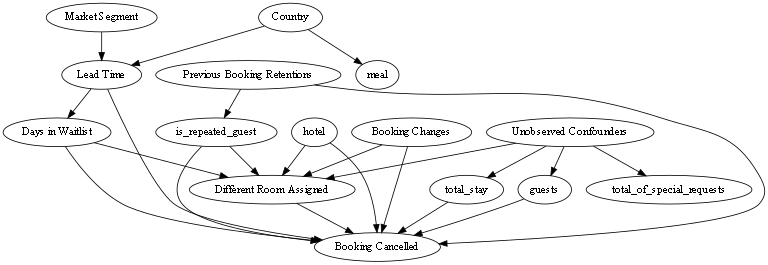

In [58]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Step-2: Identify the Causal Effect

**We say that Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant**. 
Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated.

Keeping everything else constant can be thought by imagining a Counterfactual World or a paralell universe where everything was same uptill the point when the treatment was introduced. In the factual world the treatment was provided whereas in the Counterfactual world it wasn’t. Thus any change in Outcome that we might be observing would be solely due to the Treatment.

Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated.

In [59]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|total_stay,hotel,guests,is_
d[different_room_assigned]                                                    

                                                     
repeated_guest,days_in_waiting_list,booking_changes))
                                                     
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,hotel,guests,is_repeated_guest,days_in_waiting_list,booking_changes,U) = P(is_canceled|different_room_assigned,total_stay,hotel,guests,is_repeated_guest,days_in_waiting_list,booking_changes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step-3: Estimate identified cause

Causal effect is the magnitude by which the Outcome changes due to a unit change in Treatment.

In [60]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

propensity_score_weighting


c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|total_stay,hotel,guests,is_
d[different_room_assigned]                                                    

                                                     
repeated_guest,days_in_waiting_list,booking_changes))
                                                     
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,hotel,guests,is_repeated_guest,days_in_waiting_list,booking_changes,U) = P(is_canceled|different_room_assigned,total_stay,hotel,guests,is_repeated_guest,days_in_waiting_list,booking_changes)

## Realized estimand
b: is_canceled~different_room_assigned+total_stay+hotel+guests+is_repeated_guest+days_in_waiting_li

The result is surprising. It means that having a different room assigned **decreases** the chances of a cancellation. 

### Step 4: Refute the obtained results

Note that the causal part does not come from data. It comes from your assumptions that lead to identification. Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

There exist several different refutation methods to verify our assumptions:

- **Add Random Common Cause:** Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then there shouldn’t much variation in the causal estimate. In other words, does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? *(It should not)*

In [61]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Refute: Add a random common cause
Estimated effect:-0.35433767584329184
New effect:-0.35433692815039053
p value:0.5



- **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? *(The effect should go to zero)*

In [62]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\miche\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Refute: Use a Placebo Treatment
Estimated effect:-0.35433767584329184
New effect:-3.268969399926047e-05
p value:0.49



### Notes:

By using multiple robustness checks, we have validated that our causal assumptions were indeed correct!

This tells us that on an average the Probability of a hotel booking being cancelled decreases by ~36% when the Person is assigned the same room compared to the case when he is assigned a different room than what he had chosen during booking.

However, tere could also be other mechanisms at play. Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low? In that case, the graph is missing a critical variable on when these events happen. Does *different_room_assigned* happen mostly on the day of the booking? Knowing that variable can help improve the graph and our analysis.